# **XLNET**

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

In [3]:
#load the cleaned dataset which was saved in preprocessing
cleaned_data=pd.read_csv("/content/cleaned_dataset_new.csv")

In [4]:
cleaned_data.shape

(8675, 4)

In [5]:
cleaned_data.head()

,type,posts,Cleaned_Posts,Encoded_Type
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,http www youtube com watch v qsxhcwe krw http ...,8
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack posts alarming sex boring positio...,3
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one https www youtube com watch v fhigbol...,11
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...,10
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,2


In [6]:
cleaned_data["type"].value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

In [7]:
#Initiate the tokenizer and set sequence length
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
max_length = 512

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [8]:
#lets define the tokenization function
def tokenize_text(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
cleaned_data['tokenized_text'] = cleaned_data['Cleaned_Posts'].apply(tokenize_text)

In [9]:
#after tokenization
cleaned_data.head()

,type,posts,Cleaned_Posts,Encoded_Type,tokenized_text
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,http www youtube com watch v qsxhcwe krw http ...,8,"[input_ids, token_type_ids, attention_mask]"
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack posts alarming sex boring positio...,3,"[input_ids, token_type_ids, attention_mask]"
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one https www youtube com watch v fhigbol...,11,"[input_ids, token_type_ids, attention_mask]"
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...,10,"[input_ids, token_type_ids, attention_mask]"
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,2,"[input_ids, token_type_ids, attention_mask]"


In [10]:
#split the training and testing test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    cleaned_data['tokenized_text'].tolist(),
    cleaned_data['Encoded_Type'].tolist(),
    test_size=0.2,
    random_state=42
)
#setting up the inputs and attention masks
train_inputs = torch.cat([text['input_ids'] for text in train_texts], dim=0)
train_masks = torch.cat([text['attention_mask'] for text in train_texts], dim=0)
train_labels = torch.tensor(train_labels)

In [11]:
test_inputs = torch.cat([text['input_ids'] for text in test_texts], dim=0)
test_masks = torch.cat([text['attention_mask'] for text in test_texts], dim=0)
test_labels = torch.tensor(test_labels)

In [12]:
#set the batch size and load the tensors for training and testing
batch_size = 8

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [13]:
#lets define the model and the number of labels
model = XLNetForSequenceClassification.from_pretrained(
    'xlnet-base-cased',
    num_labels=16
)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
#defining the optimizer for our model
optimizer = AdamW(model.parameters(), lr=2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
#setting the epochs and checking for GPU devices
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [16]:
#training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}', unit=' batches'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average training loss: {avg_train_loss:.4f}')
#evaluation
model.eval()
predictions = []
true_labels = []

for batch in tqdm(test_dataloader, desc='Evaluating', unit=' batches'):
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
    labels = batch[2].cpu().numpy()
    true_labels.extend(labels)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions.extend(np.argmax(logits.cpu().numpy(), axis=1))

Epoch 1: 100%|██████████| 868/868 [22:08<00:00,  1.53s/ batches]


Average training loss: 1.8415


Epoch 2: 100%|██████████| 868/868 [22:08<00:00,  1.53s/ batches]


Average training loss: 1.2321


Epoch 3: 100%|██████████| 868/868 [22:07<00:00,  1.53s/ batches]


Average training loss: 1.0286


Epoch 4: 100%|██████████| 868/868 [22:07<00:00,  1.53s/ batches]


Average training loss: 0.8751


Epoch 5: 100%|██████████| 868/868 [22:08<00:00,  1.53s/ batches]


Average training loss: 0.7185


Evaluating: 100%|██████████| 217/217 [02:54<00:00,  1.24 batches/s]


In [18]:
#lets see the accuracy of our model
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6663


In [19]:
from sklearn.preprocessing import LabelEncoder

# true_labels contains the target labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(true_labels)

# Print the classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.72      0.56      0.63        41
           1       0.69      0.67      0.68       125
           2       0.54      0.64      0.58        44
           3       0.65      0.59      0.62       135
           4       0.43      0.43      0.43         7
           5       0.00      0.00      0.00         8
           6       1.00      0.29      0.44         7
           7       0.80      0.53      0.64        15
           8       0.82      0.48      0.60       288
           9       0.67      0.83      0.74       370
          10       0.52      0.77      0.62       193
          11       0.73      0.72      0.72       293
          12       0.82      0.62      0.71        45
          13       0.58      0.64      0.61        53
          14       0.61      0.50      0.55        44
          15       0.70      0.57      0.63        67

    accuracy                           0.67      1735
   macro avg       0.64   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Get unique encoded labels
unique_encoded_labels = cleaned_data['Encoded_Type'].unique()

# Create a dictionary to map encoded labels to personality types
encoded_label_mapping = {}
for label in unique_encoded_labels:
    #getting the encoded types from the dataset
    personality_type = cleaned_data[cleaned_data['Encoded_Type'] == label]['type'].iloc[0]
    encoded_label_mapping[label] = personality_type

print(encoded_label_mapping)


{8: 'INFJ', 3: 'ENTP', 11: 'INTP', 10: 'INTJ', 2: 'ENTJ', 0: 'ENFJ', 9: 'INFP', 1: 'ENFP', 13: 'ISFP', 15: 'ISTP', 12: 'ISFJ', 14: 'ISTJ', 7: 'ESTP', 5: 'ESFP', 6: 'ESTJ', 4: 'ESFJ'}


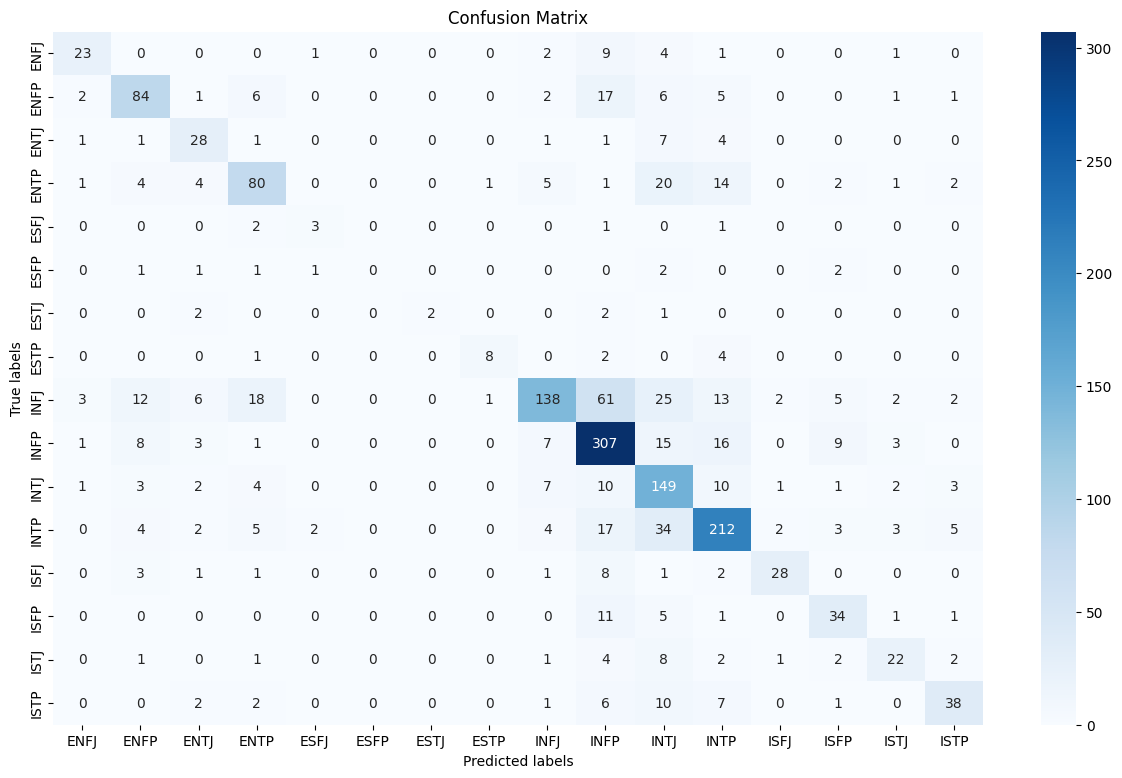

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Encoded mappings
encoded_mappings = {8: 'INFJ', 3: 'ENTP', 11: 'INTP', 10: 'INTJ', 2: 'ENTJ', 0: 'ENFJ', 9: 'INFP', 1: 'ENFP', 13: 'ISFP', 15: 'ISTP', 12: 'ISFJ', 14: 'ISTJ', 7: 'ESTP', 5: 'ESFP', 6: 'ESTJ', 4: 'ESFJ'}

# Replacing encoded labels with respective personality types
labels_4 = [encoded_mappings[label] for label in np.unique(np.concatenate((true_labels, predictions)))]

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(15, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_4, yticklabels=labels_4)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score

# Convert the predictions and true labels to personality types
predicted_types = [encoded_mappings[p] for p in predictions]
true_types = [encoded_mappings[p] for p in true_labels]

# Calculate the accuracy
accuracy = accuracy_score(true_types, predicted_types)

print(f"Overall Accuracy: {accuracy:.4f}")

# Calculate individual accuracy for each personality type
individual_accuracies = {}
for personality_type in encoded_mappings.values():
    true_indices = [i for i, t in enumerate(true_types) if t == personality_type]
    predicted_indices = [i for i, p in enumerate(predicted_types) if p == personality_type]
    correct_indices = set(true_indices) & set(predicted_indices)
    individual_accuracies[personality_type] = len(correct_indices) / len(true_indices)

# Print individual accuracy for each personality type
for personality_type, accuracy in individual_accuracies.items():
    print(f"Accuracy for {personality_type}: {accuracy:.4f}")

Overall Accuracy: 0.6663
Accuracy for INFJ: 0.4792
Accuracy for ENTP: 0.5926
Accuracy for INTP: 0.7235
Accuracy for INTJ: 0.7720
Accuracy for ENTJ: 0.6364
Accuracy for ENFJ: 0.5610
Accuracy for INFP: 0.8297
Accuracy for ENFP: 0.6720
Accuracy for ISFP: 0.6415
Accuracy for ISTP: 0.5672
Accuracy for ISFJ: 0.6222
Accuracy for ISTJ: 0.5000
Accuracy for ESTP: 0.5333
Accuracy for ESFP: 0.0000
Accuracy for ESTJ: 0.2857
Accuracy for ESFJ: 0.4286


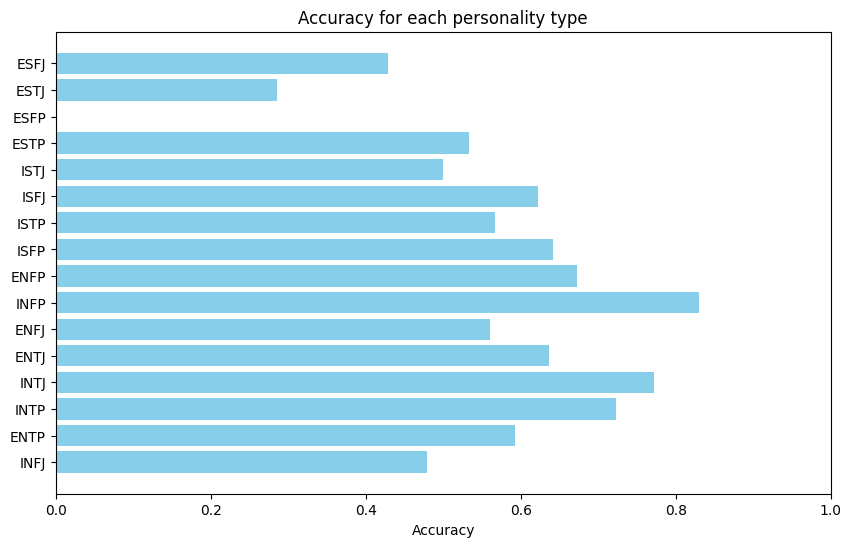

In [23]:
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(individual_accuracies.keys()),individual_accuracies.values(), color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy for each personality type')
plt.xlim(0, 1)  # Limiting x-axis from 0 to 1
plt.show()

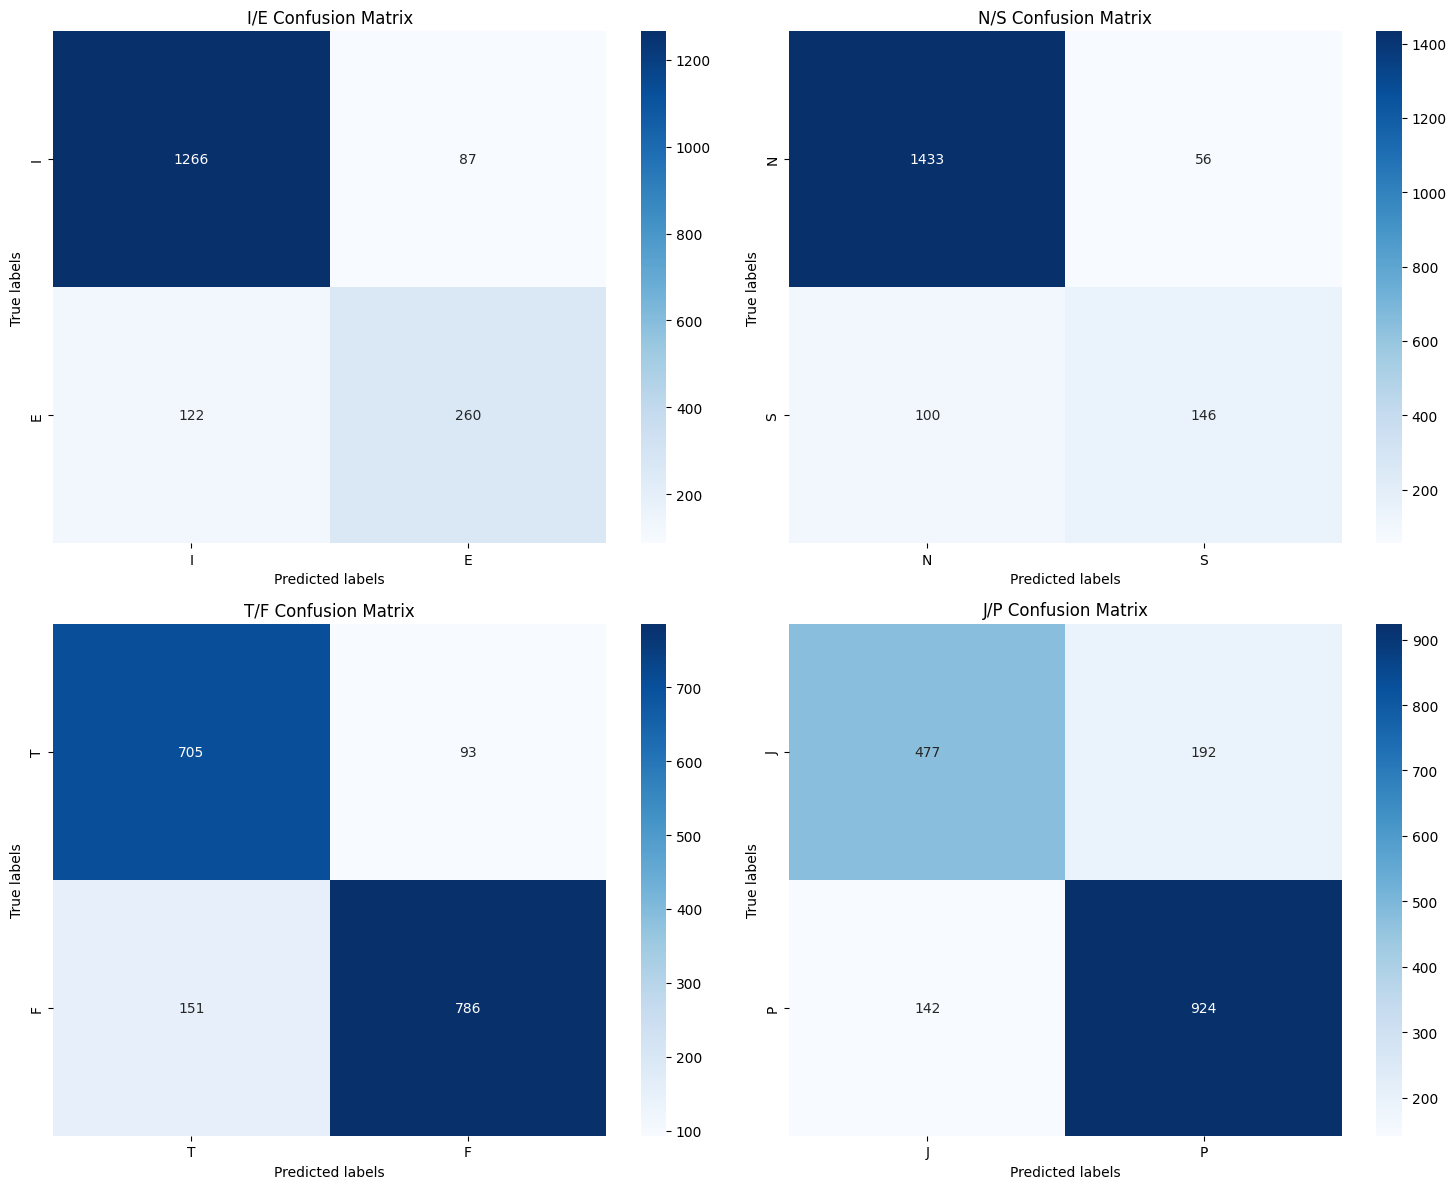

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Classify the predictions and true labels into 16 personality types based on individual accuracies
predicted_types = [encoded_mappings[p] for p in predictions]
true_types = [encoded_mappings[p] for p in true_labels]

# Separate predicted and true types into I/E, N/S, T/F, J/P axes
IE_types = ['I', 'E']
NS_types = ['N', 'S']
TF_types = ['T', 'F']
JP_types = ['J', 'P']

# Initialize confusion matrices for each personality trait
cm_IE = np.zeros((2, 2), dtype=int)
cm_NS = np.zeros((2, 2), dtype=int)
cm_TF = np.zeros((2, 2), dtype=int)
cm_JP = np.zeros((2, 2), dtype=int)

# Fill confusion matrices
for true_type, pred_type in zip(true_types, predicted_types):
    true_IE, true_NS, true_TF, true_JP = true_type[0], true_type[1], true_type[2], true_type[3]
    pred_IE, pred_NS, pred_TF, pred_JP = pred_type[0], pred_type[1], pred_type[2], pred_type[3]

    true_IE_idx = IE_types.index(true_IE)
    pred_IE_idx = IE_types.index(pred_IE)
    true_NS_idx = NS_types.index(true_NS)
    pred_NS_idx = NS_types.index(pred_NS)
    true_TF_idx = TF_types.index(true_TF)
    pred_TF_idx = TF_types.index(pred_TF)
    true_JP_idx = JP_types.index(true_JP)
    pred_JP_idx = JP_types.index(pred_JP)

    cm_IE[true_IE_idx][pred_IE_idx] += 1
    cm_NS[true_NS_idx][pred_NS_idx] += 1
    cm_TF[true_TF_idx][pred_TF_idx] += 1
    cm_JP[true_JP_idx][pred_JP_idx] += 1

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.heatmap(cm_IE, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], xticklabels=IE_types, yticklabels=IE_types)
axes[0, 0].set_title('I/E Confusion Matrix')
axes[0, 0].set_xlabel('Predicted labels')
axes[0, 0].set_ylabel('True labels')

sns.heatmap(cm_NS, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1], xticklabels=NS_types, yticklabels=NS_types)
axes[0, 1].set_title('N/S Confusion Matrix')
axes[0, 1].set_xlabel('Predicted labels')
axes[0, 1].set_ylabel('True labels')

sns.heatmap(cm_TF, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], xticklabels=TF_types, yticklabels=TF_types)
axes[1, 0].set_title('T/F Confusion Matrix')
axes[1, 0].set_xlabel('Predicted labels')
axes[1, 0].set_ylabel('True labels')

sns.heatmap(cm_JP, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], xticklabels=JP_types, yticklabels=JP_types)
axes[1, 1].set_title('J/P Confusion Matrix')
axes[1, 1].set_xlabel('Predicted labels')
axes[1, 1].set_ylabel('True labels')

plt.tight_layout()
plt.show()

In [26]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# specifing the path for saving the model
output_dir = "/content/drive/MyDrive/XLNet"

# Save the model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/XLNet/tokenizer_config.json',
 '/content/drive/MyDrive/XLNet/special_tokens_map.json',
 '/content/drive/MyDrive/XLNet/spiece.model',
 '/content/drive/MyDrive/XLNet/added_tokens.json')

In [28]:
!pip install huggingface_hub

!huggingface-cli login
#Log in using a token from huggingface.co/settings/tokens
#Create a model or dataset repo from the CLI if needed
!huggingface-cli repo create repo_name --type {model, dataset, space}


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

In [29]:
from huggingface_hub import notebook_login

In [30]:
notebook_login()

In [31]:
#pushing our trained model to the hub
model.push_to_hub("Kavya11/XLNet-Personality-Classification")

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Kavya11/XLNet-Personality-Classification/commit/2932e628fb25eb02f7677f9dcfa8a9582d286dde', commit_message='Upload XLNetForSequenceClassification', commit_description='', oid='2932e628fb25eb02f7677f9dcfa8a9582d286dde', pr_url=None, pr_revision=None, pr_num=None)

In [34]:
import torch
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# Load pre-trained model and tokenizer
model = XLNetForSequenceClassification.from_pretrained("Kavya11/XLNet-Personality-Classification")
#tokenizer = XLNetTokenizer.from_pretrained("Kavya11/XLNet-Personality-Classification")

# Function to classify personality type based on input text
def classify_personality(input_text):
    # Tokenize input text
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)

    # Perform classification
    outputs = model(**inputs)

    # Get predicted label
    predicted_label = torch.argmax(outputs.logits).item()

    return predicted_label

# User input
user_input = input("Enter a paragraph describing yourself: ")

# Classify personality type
predicted_label = classify_personality(user_input)

# Map predicted label to personality type
#personality_types = {{8: 'INFJ', 3: 'ENTP', 11: 'INTP', 10: 'INTJ', 2: 'ENTJ', 0: 'ENFJ', 9: 'INFP', 1: 'ENFP', 13: 'ISFP', 15: 'ISTP', 12: 'ISFJ', 14: 'ISTJ', 7: 'ESTP', 5: 'ESFP', 6: 'ESTJ', 4: 'ESFJ'}}

predicted_personality = encoded_label_mapping[predicted_label]

print("Predicted personality type:", predicted_personality)


Enter a paragraph describing yourself: Woke up this morning with a melody stuck in my head. Anyone else ever get song ideas in their dreams? #musicmaker Just finished reading "The Little Prince." So beautifully simple, yet so profound. Makes you question everything. #philosophy #books Spending the afternoon sketching in the park. The sunlight filtering through the leaves is pure magic. #naturephotography #artist ☀️ Feeling discouraged by the news lately. Wish people focused on understanding each other more. #peacebuilding #empathy Came across the most amazing quote: "We don't inherit the earth from our ancestors, we borrow it from our children." Let's leave them a better world. #sustainability #environment Anyone else ever feel overwhelmed by the beauty of nature? The vastness of the ocean makes me feel both small and strangely hopeful. #oceanlover #wonder Finished a new painting! It's a whimsical landscape inspired by a dream I had. What do you think? #fantasyart #imagination ✨ Just d

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted personality type: INFP
